<a href="https://colab.research.google.com/github/rkdune/roadtojepa/blob/main/autoencoder_brain_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install allensdk

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns

In [4]:
# Download the data
cache = BrainObservatoryCache(manifest_file='boc_manifest.json')

expt_id = 649409874
data_set = cache.get_ophys_experiment_data(expt_id)
print(f"Using experiment ID: {expt_id}")

# Get experiments and find one with available data
# experiments = cache.get_ophys_experiments()
# data_set = None
# for experiment in experiments:
#     expt_id = experiment['id']
#     try:
#         data_set = cache.get_ophys_experiment_data(expt_id)
#         # If we get here, we've found a valid dataset
#         print(f"Using experiment ID: {expt_id}")
#         break
#     except Exception as e:
#         print(f"Skipping experiment {expt_id}: {str(e)}")

# if data_set is None:
#     raise Exception("No valid experiments found with available data.")

# Get the fluorescence traces
dff_traces = data_set.get_dff_traces()
neuron_traces = dff_traces[1]

# Normalize the data
neuron_traces = (neuron_traces - np.min(neuron_traces)) / (np.max(neuron_traces) - np.min(neuron_traces))

# Reshape the data for the autoencoder
X = neuron_traces.T
X = X.reshape((X.shape[0], 1, X.shape[1]))  # (samples, channels, time_steps)

2024-07-09 03:39:17,467 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/650079447
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/650079447


Using experiment ID: 649409874


In [5]:
print(f"Data shape: {X.shape}")

Data shape: (118996, 1, 26)


note for experiment id: 649409874 works?

In [6]:
# Split the data
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

# Create DataLoaders
train_dataset = TensorDataset(X_train, X_train)
test_dataset = TensorDataset(X_test, X_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [1]:
# Assuming X has shape (118996, 1, 26)
# Let's reshape it to (118996, 26) for easier plotting
data = X.squeeze(axis=1)

# # 1. Time series plot of a few neurons
# plt.figure(figsize=(15, 5))
# for i in range(5):  # Plot first 5 neurons
#     plt.plot(data[:1000, i], label=f'Neuron {i+1}')
# plt.title('Activity of 5 Neurons over Time')
# plt.xlabel('Time Steps')
# plt.ylabel('Normalized Activity')
# plt.legend()
# plt.show()

# # 2. Heatmap of neuron activities
# plt.figure(figsize=(12, 8))
# sns.heatmap(data[:1000, :].T, cmap='viridis')
# plt.title('Heatmap of Neuron Activities')
# plt.xlabel('Time Steps')
# plt.ylabel('Neurons')
# plt.show()

# # 3. Distribution of activities for each neuron
# plt.figure(figsize=(15, 5))
# plt.boxplot([data[:, i] for i in range(data.shape[1])])
# plt.title('Distribution of Activities for Each Neuron')
# plt.xlabel('Neuron')
# plt.ylabel('Normalized Activity')
# plt.show()

# # 4. Correlation matrix between neurons
# correlation_matrix = np.corrcoef(data.T)
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
# plt.title('Correlation Matrix Between Neurons')
# plt.show()

# # 5. Average activity over time
# avg_activity = data.mean(axis=1)
# plt.figure(figsize=(15, 5))
# plt.plot(avg_activity[:1000])
# plt.title('Average Neuron Activity Over Time')
# plt.xlabel('Time Steps')
# plt.ylabel('Average Normalized Activity')
# plt.show()

NameError: name 'X' is not defined

In [8]:
class Autoencoder(nn.Module):
    def __init__(self, input_features):
        super(Autoencoder, self).__init__()
        self.input_features = input_features

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2, padding=1),
            nn.Conv1d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2, padding=1),
            nn.Conv1d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2, padding=1)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv1d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv1d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv1d(32, 1, kernel_size=3, padding=1),
            nn.Upsample(size=input_features),  # Ensure output matches input size
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [9]:
# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model with the correct input feature size
input_features = X.shape[2]  # This should be 26 based on your data
model = Autoencoder(input_features).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training loop
num_epochs = 2
train_losses = []
test_losses = []

In [10]:
print("Input data shape:", X.shape)

Input data shape: (118996, 1, 26)


In [11]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_features, _ in train_loader:
        batch_features = batch_features.to(device)
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_features)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_features, _ in test_loader:
            batch_features = batch_features.to(device)
            outputs = model(batch_features)
            loss = criterion(outputs, batch_features)
            test_loss += loss.item()
    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.8f}, Test Loss: {test_loss:.8f}')

Epoch [1/2], Train Loss: 0.00222869, Test Loss: 0.00074539
Epoch [2/2], Train Loss: 0.00066056, Test Loss: 0.00063759


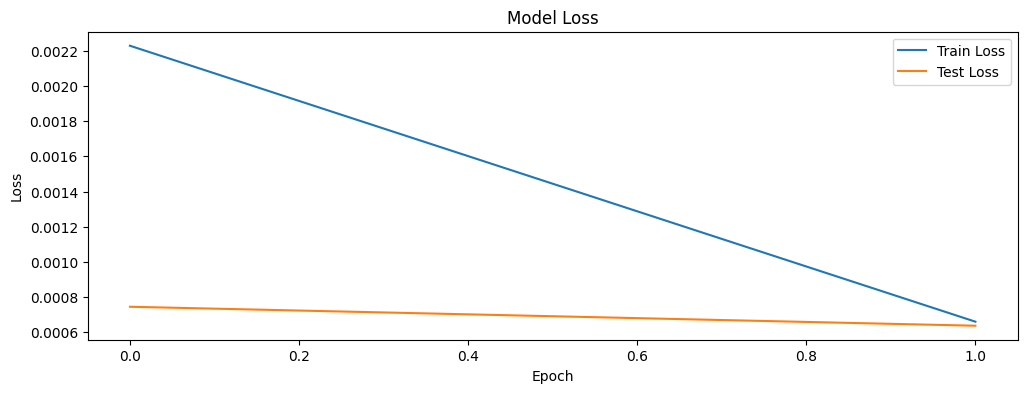

In [12]:
# Plot the training history
plt.figure(figsize=(12, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Encode and decode some test traces
model.eval()
with torch.no_grad():
    test_samples = X_test[:5].to(device)
    reconstructed = model(test_samples).cpu().numpy()

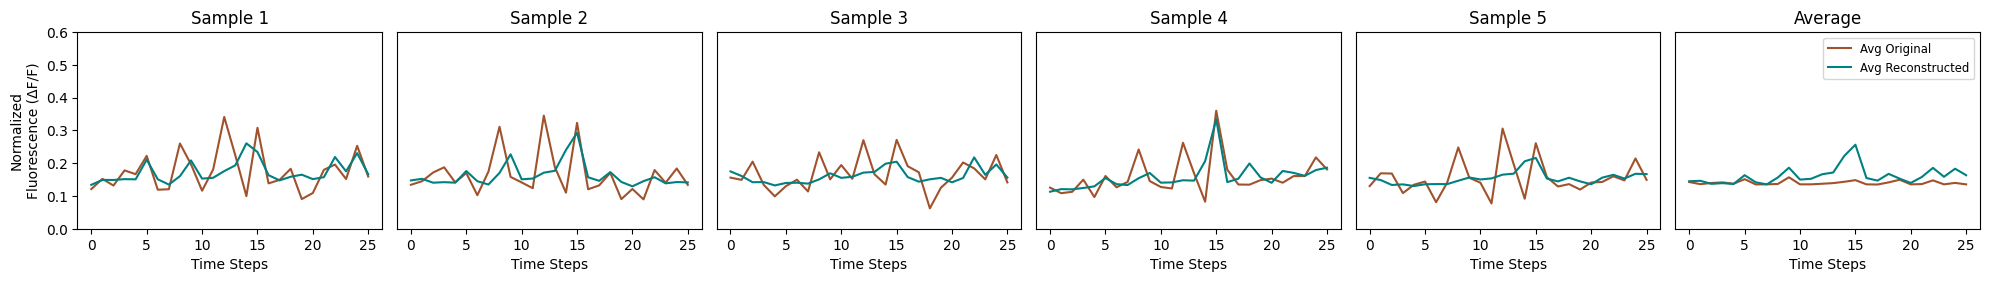

In [50]:
# Select a few samples from the test set
n = 5
test_samples = X_test[:n].to(device)
reconstructed = model(test_samples).cpu().detach()

# Calculate average activity
avg_original = torch.mean(X_test[:, 0, :], dim=0)
avg_reconstructed = torch.mean(reconstructed[:, 0, :], dim=0)

# Display original and reconstructed traces, including average
plt.figure(figsize=(20, 3))  # Slightly wider to accommodate the 6th plot
for i in range(n + 1):  # n+1 to include the average plot
    ax = plt.subplot(1, n + 1, i + 1)

    if i < n:
        # Individual samples
        plt.plot(X_test[i, 0, :].cpu().numpy(), label='Original', alpha=1, color = "sienna")
        plt.plot(reconstructed[i, 0, :].numpy(), label='Reconstructed', alpha=1, linestyle='-', color = "teal")
        plt.title(f"Sample {i+1}")
    else:
        # Average plot
        plt.plot(avg_original.cpu().numpy(), label='Avg Original', alpha=1, color = "sienna")
        plt.plot(avg_reconstructed.numpy(), label='Avg Reconstructed', alpha=1, linestyle='-', color = "teal")
        plt.title("Average")

    plt.ylim(0, 0.6)

    if i == 0:
        plt.ylabel("Normalized\nFluorescence (ΔF/F)")
    else:
        plt.yticks([])

    plt.xlabel("Time Steps")

    if i == n:  # Add legend to the last plot (average)
        plt.legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()